In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Apple

In [27]:
ticker = yf.Ticker('AAPL')
aapl_df = ticker.history(start='2019-01-01', end='2022-10-01', interval = "1d")

In [28]:
aapl_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-31,38.315788,38.516395,37.820314,38.124851,140014000,0.0,0.0
2019-01-02,37.436017,38.393128,37.276498,38.168350,148158800,0.0,0.0
2019-01-03,34.799136,35.219685,34.320582,34.366505,365248800,0.0,0.0
2019-01-04,34.932065,35.903677,34.755630,35.833584,234428400,0.0,0.0
2019-01-07,35.939928,35.971349,35.263183,35.753822,219111200,0.0,0.0


In [29]:
print('Missing values: ', aapl_df['Close'].isnull().sum())

Missing values:  0


In [30]:
def compute_statistics(X):
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

compute_statistics(aapl_df['Close'])

mean1=68.888776, mean2=146.177637
variance1=602.971803, variance2=295.666559


In [31]:
aapl_df = aapl_df.resample("D").mean().ffill()

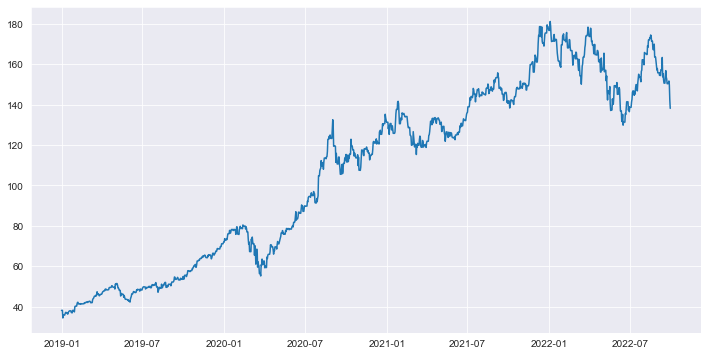

In [32]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df['Close'])
plt.show()

По графику и по расчетам статистик видно, что среднее значение увеличивается, значит присутствует восходящий тренд. Дисперсия изменяется. Сезонности визуально не наблюдается.
Таким образом, ряд нестационарный.
Дополнительно для проверки стационарности проведем тест Дикки Фуллера и построим графики коррелограмм.

In [33]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 14), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   -1.412783
p-value                           0.576133
#Lags Used                        1.000000
Number of Observations Used    1368.000000
Critical Value (1%)              -3.435139
Critical Value (5%)              -2.863655
Critical Value (10%)             -2.567896
dtype: float64


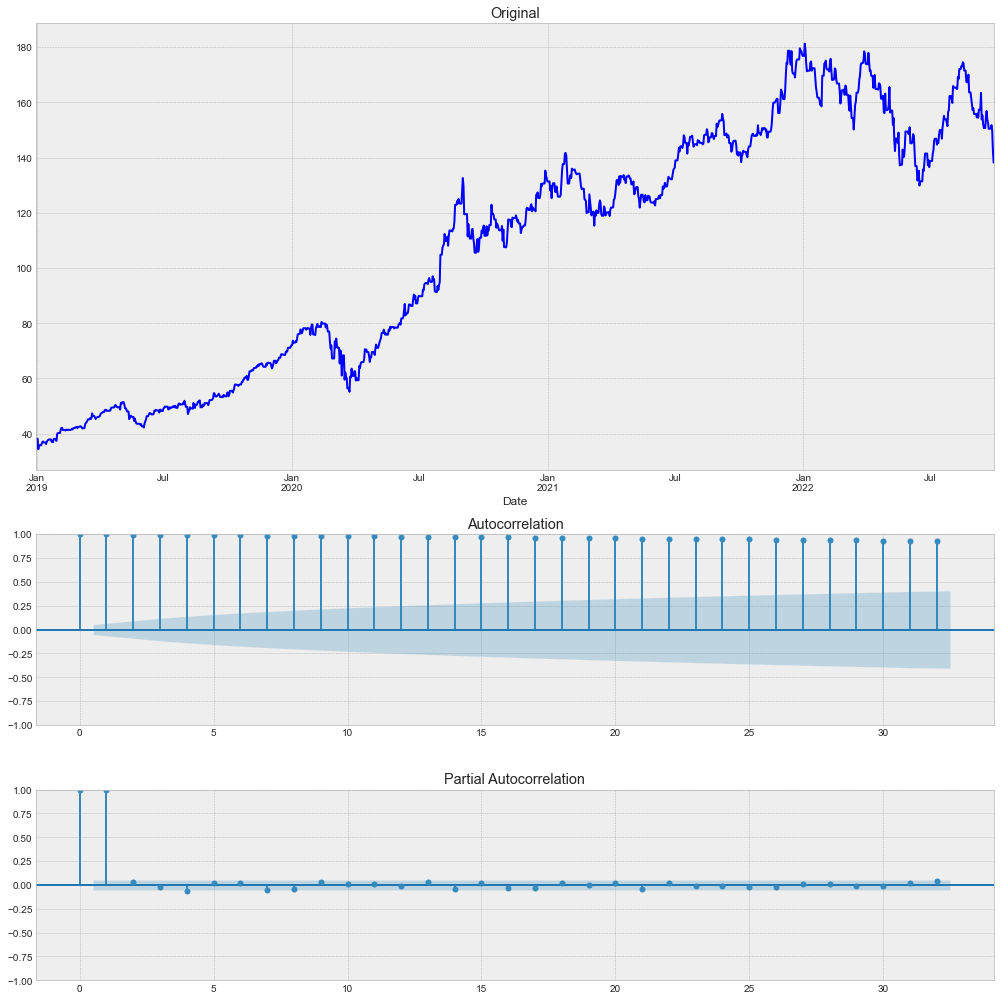

In [34]:
series = aapl_df['Close']
tsplot(series)

Тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда (p-value > 0.05). 
Значение ACF для лага 1  велико, близко к единице и очень медленно уменьшается. Это также указывает на нестационарность ряда.

Проведем декомпозицию временного ряда, чтобы выделить составляющие временного ряда: тренд, сезонность, ошибки

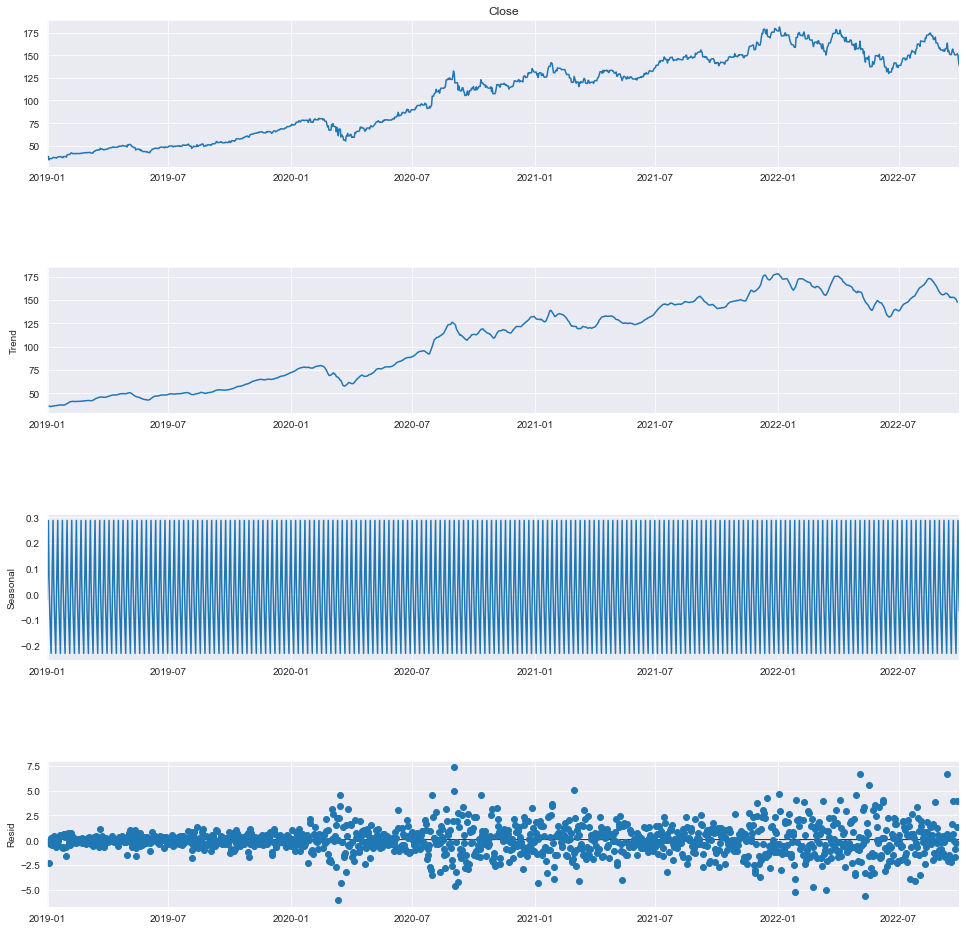

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

series_decomposed = seasonal_decompose(aapl_df['Close'], model='additive')
series_decomposed_multi = seasonal_decompose(aapl_df['Close'], model='multiplicative')

fig = series_decomposed.plot()
fig.set_size_inches((15,15))

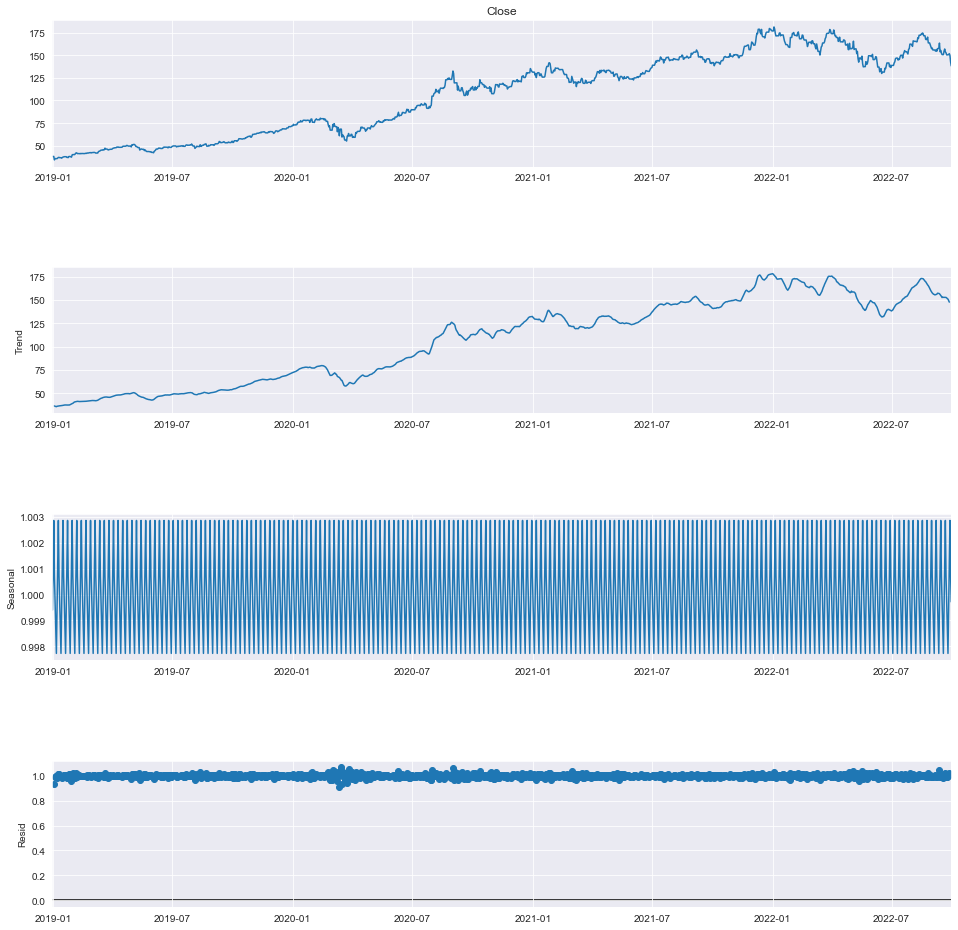

In [36]:
fig = series_decomposed_multi.plot()
fig.set_size_inches((15,15))

Results of Dickey-Fuller Test:
Test Statistic                  -39.896345
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1368.000000
Critical Value (1%)              -3.435139
Critical Value (5%)              -2.863655
Critical Value (10%)             -2.567896
dtype: float64


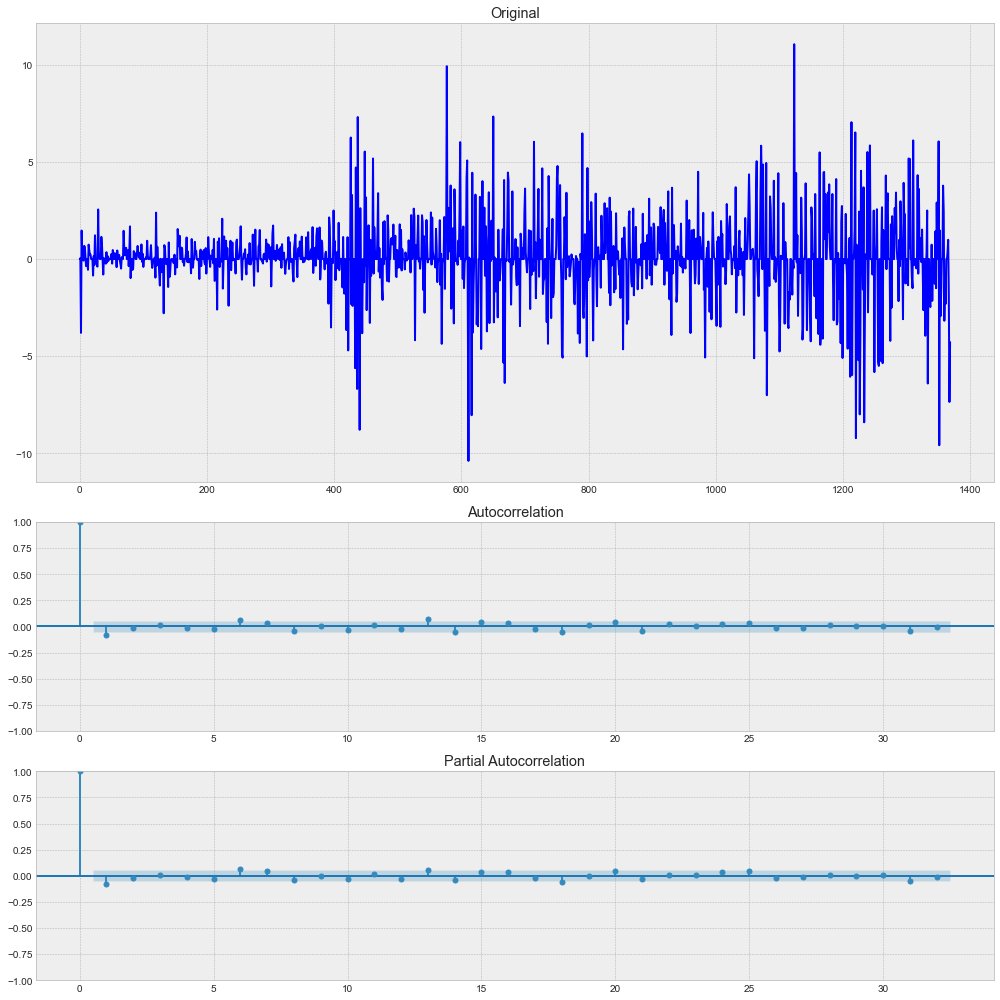

In [37]:
ts_diff = np.diff(aapl_df.Close)
aapl_df['diff_Close'] = np.append([0], ts_diff)
tsplot(ts_diff)

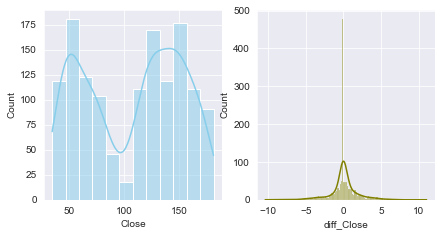

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

sns.histplot(data=aapl_df, x="Close", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=aapl_df, x="diff_Close", kde=True, color="olive", ax=axs[1])
plt.show()

После проведения дифференцирования, тест Дикки Фуллера показал, что ряд стационарный. Автокорреляция отсутствует.
Вывели распределения цены закрытия до и после дифференцирования. Распределение цены закрытия после дифференцирования близко к нормальному.

### Coca-cola

In [39]:
ticker = yf.Ticker('KO')
ko_df = ticker.history(start='2019-01-01', end='2022-10-01', interval = "1d")

In [40]:
ko_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-31,42.205391,42.249826,41.734366,42.080967,10576300,0.0,0
2019-01-02,41.716596,41.965440,41.378884,41.707710,11603700,0.0,0
2019-01-03,41.609948,42.098744,41.352218,41.449978,14714400,0.0,0
2019-01-04,41.547734,42.276485,41.449974,42.276485,13013700,0.0,0
2019-01-07,42.276486,42.436456,41.681044,41.725479,13135500,0.0,0


In [41]:
print('Missing values: ', ko_df['Close'].isnull().sum())

Missing values:  0


In [42]:
compute_statistics(ko_df['Close'])

mean1=45.871259, mean2=55.600434
variance1=14.180214, variance2=27.813440


In [43]:
ko_df = ko_df.resample("D").mean().ffill()

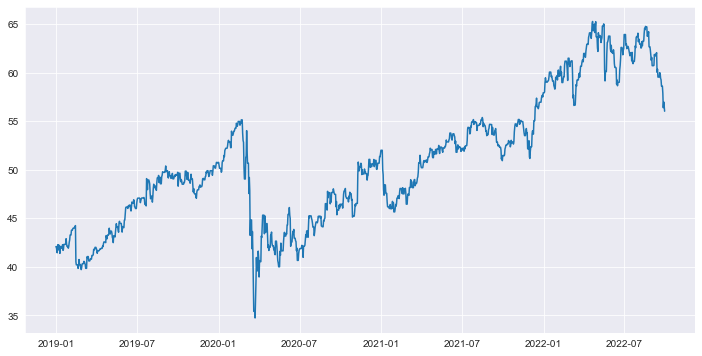

In [44]:
plt.figure(figsize=(12,6))
plt.plot(ko_df['Close'])
plt.show()

По графику и по расчетам статистик видно, что среднее значение увеличивается, значит присутствует восходящий тренд. Дисперсия изменяется. Таким образом, ряд нестационарный.
Дополнительно для проверки стационарности проведем тест Дикки Фуллера и построим графики коррелограмм.

Results of Dickey-Fuller Test:
Test Statistic                   -1.771241
p-value                           0.394830
#Lags Used                       14.000000
Number of Observations Used    1355.000000
Critical Value (1%)              -3.435185
Critical Value (5%)              -2.863675
Critical Value (10%)             -2.567907
dtype: float64


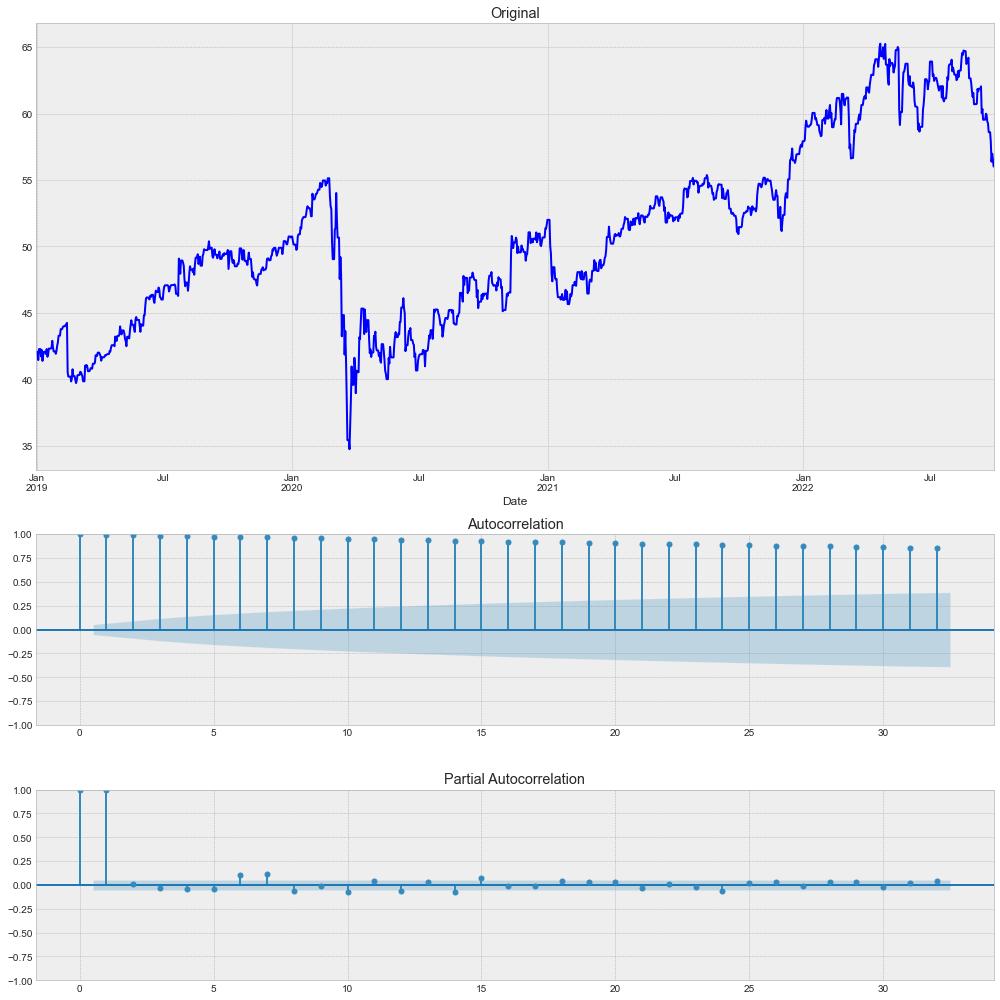

In [45]:
series = ko_df['Close']
tsplot(series)

Тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда (p-value > 0.05). 
Значение ACF для лага 1  велико, близко к единице и очень медленно уменьшается. Это также указывает на нестационарность ряда.

Проведем декомпозицию временного ряда, чтобы выделить составляющие временного ряда: тренд, сезонность, ошибки

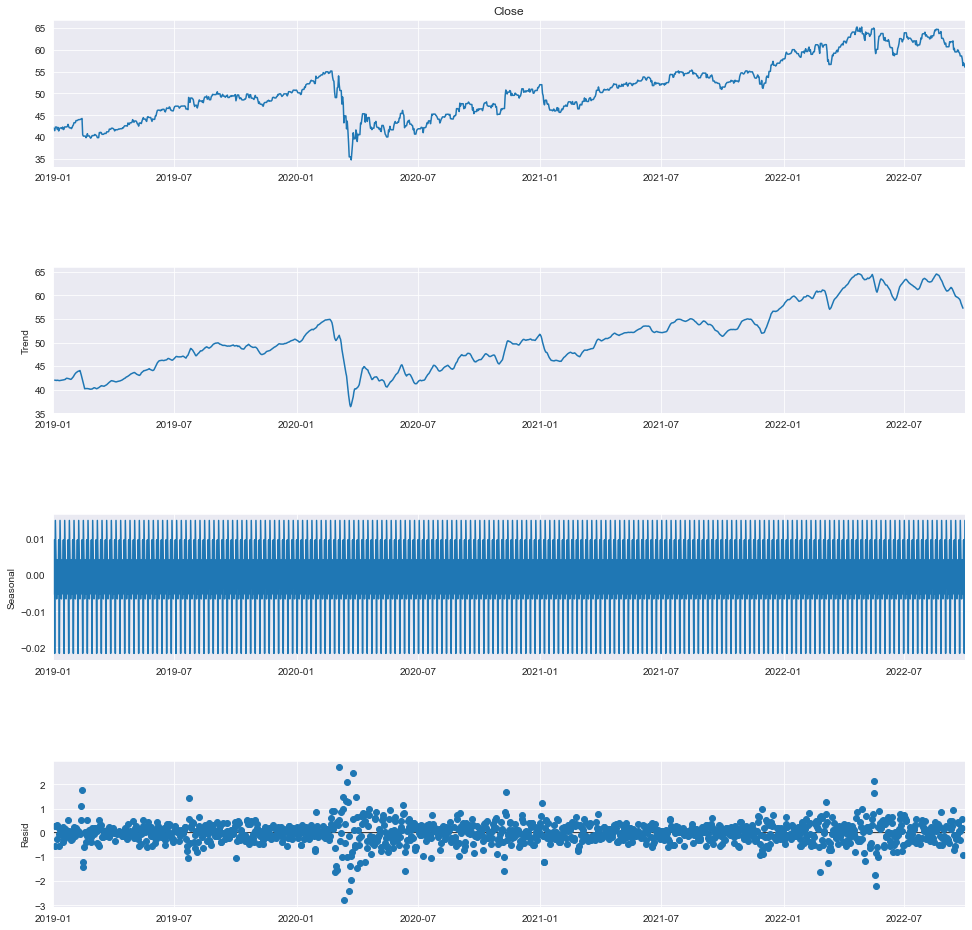

In [46]:
series_decomposed = seasonal_decompose(ko_df['Close'], model='additive')
series_decomposed_multi = seasonal_decompose(ko_df['Close'], model='multiplicative')

fig = series_decomposed.plot()
fig.set_size_inches((15,15))

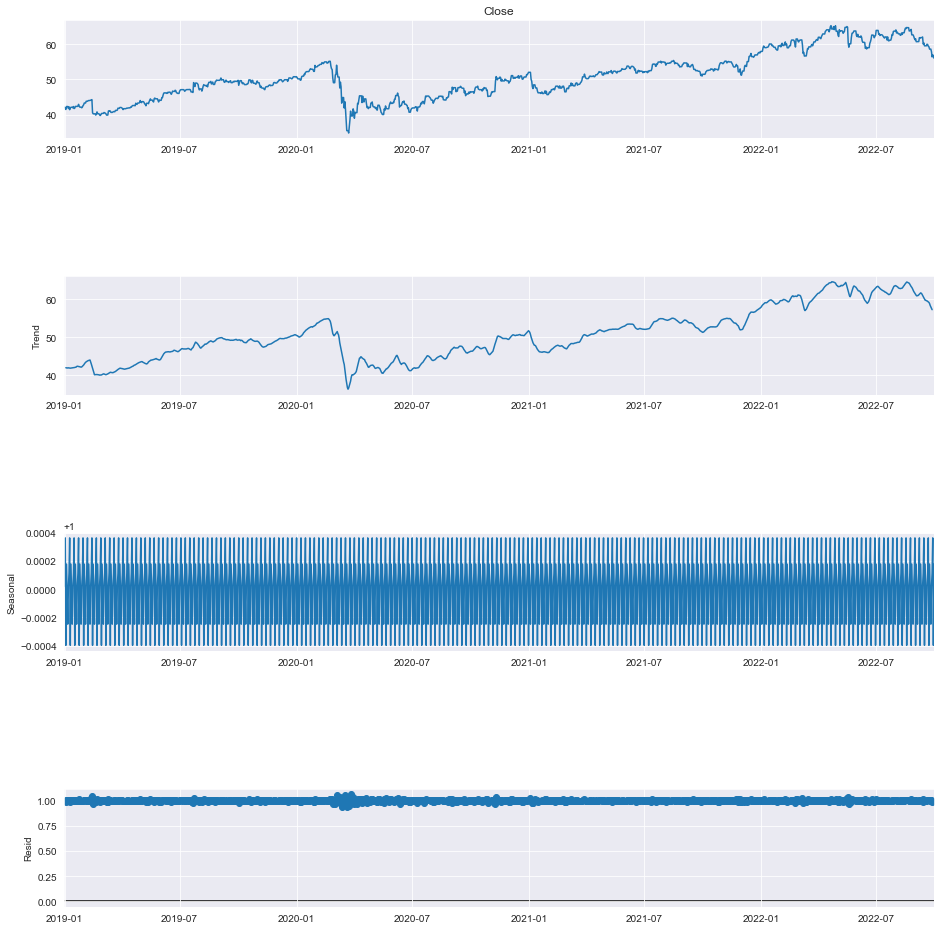

In [47]:
fig = series_decomposed_multi.plot()
fig.set_size_inches((15,15))

Results of Dickey-Fuller Test:
Test Statistic                -9.785180e+00
p-value                        6.572484e-17
#Lags Used                     1.300000e+01
Number of Observations Used    1.355000e+03
Critical Value (1%)           -3.435185e+00
Critical Value (5%)           -2.863675e+00
Critical Value (10%)          -2.567907e+00
dtype: float64


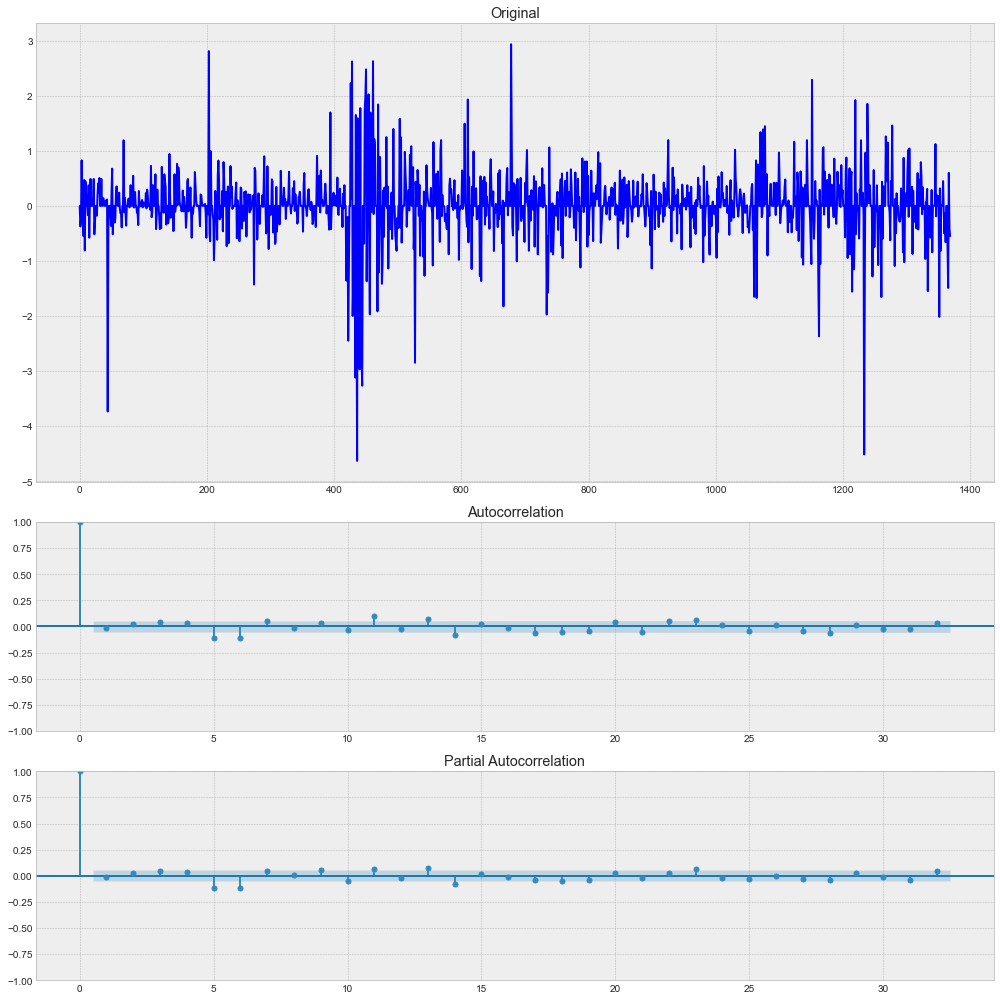

In [48]:
ts_diff = np.diff(ko_df.Close)
ko_df['diff_Close'] = np.append([0], ts_diff)
tsplot(ts_diff)

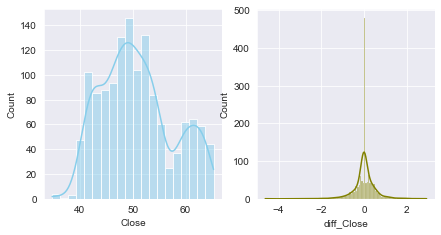

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
sns.histplot(data=ko_df, x="Close", kde=True, color="skyblue", ax=axs[0]);
sns.histplot(data=ko_df, x="diff_Close", kde=True, color="olive", ax=axs[1]);

После проведения дифференцирования, тест Дикки Фуллера показал, что ряд стационарный. Распределение цены закрытия после дифференцирования близко к нормальному
Автокорреляция отсутствует.

### Выводы

Временные ряды APPLE и Coca-Cola (цена закрытия) с 2019г по 2022г нестационарны. Проведена декомпозиция с выделением тренда, сезонности и ошибки. Приведены к стационарному диференцированием 1-го порядка. После дифференцирования на ACF и PACF значительные автокореляции отсустствуют.
